# IMAGE CAPTIONING

### Dataset used in this project is flickr8k dataset.

## loading libraries

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import cv2
import os
import glob
from PIL import Image
from time import time

from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
# from tensorflow.keras.layers.wrappers import Bidirectional
# from tensorflow.keras.layers.merge import add
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
import re
from sklearn.model_selection import train_test_split

## preprocessing text data(captions)

In [3]:
def preprocess(datas):
    return_data = []
    for data in datas:
        data=data.lower()
        data=data.replace('\\r','').replace('\\n','').replace('\\',' ').replace("n\'t",' not').replace(',',' ')\
        .replace('.',' ').replace('%',' ').replace("'s",' is').replace('-',' ').replace('"','').replace('_','').replace(':','')\
        .replace(';','').replace('!','').replace('!!','').replace(';','').replace('/',' ').replace('?',' ')

        p = re.compile('[0-9]+')
        data=p.sub('', data)

        data = re.sub(r"won't", "will not", data)
        data = re.sub(r"can\'t", "can not", data)

        # general
        data = re.sub(r"n\'t", " not", data)
        data = re.sub(r"\'re", " are", data)
        data = re.sub(r"\'s", " is", data)
        data = re.sub(r"\'d", " would", data)
        data = re.sub(r"\'ll", " will", data)
        data = re.sub(r"\'t", " not", data)
        data = re.sub(r"\'ve", " have", data)
        data = re.sub(r"\'m", " am", data)

#         data = ' '.join(e for e in data.split() if e.lower() not in stopwords)
        # data=data.lower()
        data=' '.join(data.split())
        return_data.append(data)
        
    return return_data

In [4]:
df = pd.read_csv('archive/captions.txt')
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [5]:
df['caption']=preprocess(df['caption'].values)

In [6]:
df.shape

(40455, 2)

In [7]:
df['enc_input'] = 'SOS '+df['caption']
df['enc_output'] = df['caption']+' EOS'

In [8]:
x = df[['image','enc_input']]
y = df['enc_output']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.22, random_state=42)

In [10]:
y_train.values+' '+X_train['enc_input'].values

array(['a small child dressed in green is eating with a spoon EOS SOS a small child dressed in green is eating with a spoon',
       'a football player with a red sooners jersey on EOS SOS a football player with a red sooners jersey on',
       'two men cleaning the outside windows of a yacht EOS SOS two men cleaning the outside windows of a yacht',
       ...,
       'little girl in pink skateboard EOS SOS little girl in pink skateboard',
       'a boy lays on a picnic table bench EOS SOS a boy lays on a picnic table bench',
       'a group of young people pose for a group photo while a man does a bike jump EOS SOS a group of young people pose for a group photo while a man does a bike jump'],
      dtype=object)

In [11]:
X_train['enc_input'].values

array(['SOS a small child dressed in green is eating with a spoon',
       'SOS a football player with a red sooners jersey on',
       'SOS two men cleaning the outside windows of a yacht', ...,
       'SOS little girl in pink skateboard',
       'SOS a boy lays on a picnic table bench',
       'SOS a group of young people pose for a group photo while a man does a bike jump'],
      dtype=object)

## encoding data

In [12]:
tokenizer1 = Tokenizer()
tokenizer1.fit_on_texts(y_train.values+' '+X_train['enc_input'].values)

In [13]:
len_of_captions = [len(i.split()) for i in X_train['enc_input'].values]

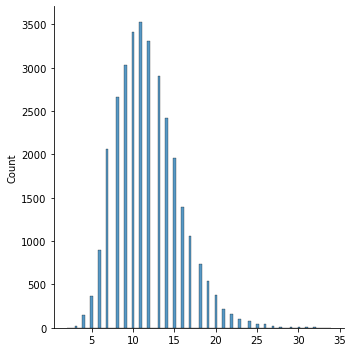

In [14]:
sns.displot(len_of_captions)

In [15]:
tokenizer1.word_index['sos']

3

In [16]:
tokenizer1.texts_to_sequences(['SOS'])

[[3]]

In [17]:
vocab_size = len(tokenizer1.index_word)
vocab_size

7693

## making embedding matrix for each token because we will feed embeded word in lstm

In [18]:
embeddings_index = dict()
f = open('D:\data\glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [19]:
eng_inp_vocab_size=max(tokenizer1.index_word.keys())
embedding_matrix = np.zeros((eng_inp_vocab_size+1, 100))
for word, i in tokenizer1.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [20]:
embedding_matrix[3]

array([ 0.39331001,  0.17557999, -0.038249  , -0.29912999, -0.27272999,
        0.71069002,  0.15098   ,  0.30083999,  0.30237001, -0.20745   ,
        0.046494  , -0.49252999, -0.2472    , -0.50089997,  0.83873999,
        0.51239002,  0.33127999, -0.70762002, -0.57999003, -0.088813  ,
       -0.15083   ,  0.67903   ,  0.43787   ,  0.22192   , -0.19656   ,
        0.32732001,  0.085472  ,  1.14839995,  0.087369  , -0.63976997,
       -0.17903   ,  0.28016999,  0.11887   ,  1.36389995, -0.57476997,
       -0.19368   , -0.22078   ,  0.50691998,  0.79896998, -0.23738   ,
       -0.61254001,  1.17480004, -0.73619002, -0.39210001,  0.29719001,
        0.22504   , -0.80861002,  0.60435998, -0.59819001,  0.34602001,
       -1.1631    ,  0.90717   , -0.39196   , -0.025512  , -0.60084999,
       -0.30131   ,  0.48583001, -0.20550001,  0.35499001, -0.16982   ,
        0.47126001, -0.21933   ,  0.046715  , -0.013335  , -0.33307999,
       -0.30162999, -1.06690001, -0.57046998,  0.66842002, -0.40

In [21]:
embedding_matrix.shape

(7694, 100)

In [82]:
np.save('embedding_matrix',embedding_matrix)

In [84]:
np.load('embedding_matrix.npy')
embedding_matrix.shape

(7694, 100)

In [79]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer1, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
image = cv2.imread('archive/Images/1000268201_693b08cb0e.jpg')
image = cv2.resize(image,(299,299))

In [22]:
image.shape

(299, 299, 3)

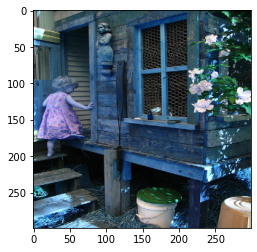

In [23]:
plt.imshow(image)

## creating dataloader for feeding data in network model

In [22]:
class Dataset:
    def __init__(self, data, embedding, tokenizer_eng, max_len, vocab_size):
        self.decoder_inps = data[0]['enc_input'].values
        self.images = data[0]['image'].values
#         self.decoder_inps = data['decoder_input_hin'].values
        self.decoder_outs = data[1].values
        self.embedding = embedding
#         self.embedding1 = embedding1
        self.tknizer_eng = tokenizer_eng
#         self.tknizer_hin_inp = tokenizer_hin_inp
#         self.tknizer_hin = tokenizer_hin
        self.max_len = max_len
        self.vocab_size=vocab_size

    def __getitem__(self, i):
        
        img = cv2.imread('archive/Images/'+self.images[i])
        img = cv2.resize(img,(224,224),interpolation=cv2.INTER_AREA)
        img = img/255.0
        
        self.decoder_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]]) # need to pass list of values
#         self.decoder_inp_seq = self.tknizer_hin_inp.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])
#         print(self.decoder_inp_seq)
        self.decoder_seq = pad_sequences(self.decoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
#         self.decoder_out_seq = pad_sequences([self.decoder_inp_seq[0][1:]], maxlen=25, dtype='int32', padding='post')
        #print(self.decoder_inp_seq1)
#         print(self.decoder_seq)
#         print(self.decoder_out_seq)
        #print(self.encoder_seq)
        self.decoder_seq1=[]
        for j in self.decoder_seq[0]:
            self.decoder_seq1.append(self.embedding[j])
            
            
#         self.decoder_out_seq1=[]
#         for i in self.decoder_out_seq[0]:
#             self.decoder_out_seq1.append(self.embedding[i])    
        #print(np.array(encoder_seq1).shape)
        
#         decoder_inp_seq1 =[]
        
#         for i in self.decoder_inp_seq[0]:
#             decoder_inp_seq1.append(self.embedding1[i])
            
#         self.decoder_out_seq1 = np.zeros((25,self.vocab_hindi+1),dtype=np.float32)
        
#         for i,d in enumerate(self.decoder_out_seq[0]):
#             self.decoder_out_seq1[i,d]=1
        
        
        
        #print(self.encoder_seq.shape)
#         print(img)
        return np.array(img), np.array(self.decoder_seq1), np.array(self.decoder_out_seq)

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        #print(dataset)
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.decoder_inps))
        #print(self.indexes)


    def __getitem__(self, i):
        #print(i,'in dataloader')
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            #print(self.dataset[j])
            data.append(self.dataset[j])
            #break
        #print(len(data),'in dataloader')
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
#         print('batch')
        #print(batch[2].shape)
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],tf.squeeze(batch[2])])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [23]:
train_dataset = Dataset((X_train,y_train), embedding_matrix, tokenizer1, 20,vocab_size)
test_dataset  = Dataset((X_test,y_test), embedding_matrix, tokenizer1,20,vocab_size)

train_dataloader = Dataloder(train_dataset, batch_size=32)
test_dataloader = Dataloder(test_dataset, batch_size=32)

In [24]:
train_dataloader[0][1].shape

TensorShape([32, 20])

## creating model using vgg16(for extracting feature vectors from images)

In [27]:
base_model = VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=layers.Input((224,224,3)),
)

In [28]:
base_model.trainable = False

In [29]:
# inp = layers.Input(shape = (224,224,3))
x = base_model.output
print(x.shape)

# feat_fr_ = base_model.layers[-5]
# print(feat_fr_.shape)
flat = layers.Flatten()(x)

dense1 = layers.Dense(4096,activation='relu')(flat)

dense2 = layers.Dense(1000,activation='relu')(dense1)
dense3 = layers.Dense(100,activation='relu')(dense2)

# r_v1 = layers.RepeatVector(20)(dense3)

decoder_inputs = tf.keras.Input(shape=(20,100))

# decoder_lstm = keras.layers.LSTM(64, return_sequences=True, return_state=True)

decoder_lstm = tf.keras.layers.LSTM(1000, return_sequences=True, return_state=True)
add1 = layers.add([dense3,decoder_inputs])
print(add1.shape)
decoder_outputs, _, _ = decoder_lstm(add1)
decoder_dense = tf.keras.layers.Dense(vocab_size+1, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


model = tf.keras.Model([base_model.input, decoder_inputs], decoder_outputs)

# conv1 = layers.Conv2D(64,3,2,padding='same',activation='relu')(inp)
# print(conv1.shape)
# conv2 = layers.Conv2D(32,3,padding='valid',activation='relu')(conv1)
# print(conv2.shape)
# conv3 = layers.Conv2D(64,3,padding='same',activation='relu')(conv2)
# print(conv3.shape)

# ##---------residual---------------
# maxp1 = layers.MaxPooling2D(3,2,padding='valid')(conv3)
# print(maxp1.shape)
# conv4 = layers.Conv2D(96,3,2,padding='valid',activation='relu')(conv3)
# print(conv4.shape)
# concat1 = layers.Concatenate(axis=3)([maxp1,conv4])
# print(concat1.shape)
# ##--------------end-residual

(None, 7, 7, 512)
(None, 20, 100)


In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

## training model

In [20]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.fit(train_dataloader, epochs=10, validation_data = test_dataloader)

Epoch 1/10
986/986 [==============================] - 517s 524ms/step - loss: 3.1229 - accuracy: 0.5095 - val_loss: 2.6329 - val_accuracy: 0.5538
Epoch 2/10
986/986 [==============================] - 524s 531ms/step - loss: 2.5172 - accuracy: 0.5685 - val_loss: 2.3339 - val_accuracy: 0.5857
Epoch 3/10
986/986 [==============================] - 532s 539ms/step - loss: 2.2596 - accuracy: 0.5913 - val_loss: 2.1593 - val_accuracy: 0.6007
Epoch 4/10
986/986 [==============================] - 531s 538ms/step - loss: 2.0846 - accuracy: 0.6076 - val_loss: 2.0324 - val_accuracy: 0.6135
Epoch 5/10
986/986 [==============================] - 531s 538ms/step - loss: 1.9532 - accuracy: 0.6216 - val_loss: 1.9531 - val_accuracy: 0.6224
Epoch 6/10
986/986 [==============================] - 548s 556ms/step - loss: 1.8464 - accuracy: 0.6332 - val_loss: 1.8909 - val_accuracy: 0.6290
Epoch 7/10
986/986 [==============================] - 531s 539ms/step - loss: 1.7551 - accuracy: 0.6437 - val_loss: 1.8385 -

In [32]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.fit(train_dataloader, epochs=10, validation_data = test_dataloader)

Epoch 1/10
986/986 [==============================] - 546s 554ms/step - loss: 1.5158 - accuracy: 0.6749 - val_loss: 1.7292 - val_accuracy: 0.6501
Epoch 2/10
986/986 [==============================] - 640s 649ms/step - loss: 1.4503 - accuracy: 0.6814 - val_loss: 1.7105 - val_accuracy: 0.6512
Epoch 3/10
986/986 [==============================] - 641s 650ms/step - loss: 1.3943 - accuracy: 0.6881 - val_loss: 1.6931 - val_accuracy: 0.6534
Epoch 4/10
986/986 [==============================] - 537s 544ms/step - loss: 1.3436 - accuracy: 0.6940 - val_loss: 1.6832 - val_accuracy: 0.6558
Epoch 5/10
986/986 [==============================] - 527s 535ms/step - loss: 1.2958 - accuracy: 0.7000 - val_loss: 1.6716 - val_accuracy: 0.6575
Epoch 6/10
986/986 [==============================] - 521s 529ms/step - loss: 1.2520 - accuracy: 0.7061 - val_loss: 1.6752 - val_accuracy: 0.6574
Epoch 7/10
986/986 [==============================] - 521s 529ms/step - loss: 1.2110 - accuracy: 0.7117 - val_loss: 1.6703 -

In [21]:
model.save('model_2.h5')

In [25]:
model1  = tf.keras.models.load_model('model_1.h5')

# converting in lite model

In [52]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

In [53]:
lite_model=converter.convert()

In [54]:
open('model.tflite','wb').write(lite_model)

535240252

# loading lite model

In [29]:
model = tf.lite.Interpreter(model_path="model.tflite")
model.allocate_tensors()

## evaluating model

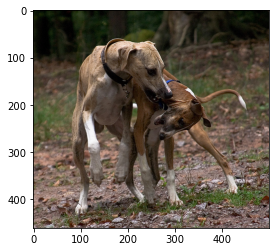

In [28]:
def predict_captions(image):
    start_word = ["sos"]
    c=0
    while True:
        par_caps = [tokenizer1.word_index[i] for i in start_word]
#         print(np.array(par_caps).shape)
        par_caps = pad_sequences([par_caps], maxlen=20, padding='post')
#         print(np.array(par_caps).shape)
        par_caps = [embedding_matrix[i,:] for i in par_caps]
#         print(np.array(par_caps).shape)
        preds = model1.predict([np.array([image]), np.array(par_caps)])
#         print(np.sum(preds[0][c]))
#         if c!=1:
        word_pred = tokenizer1.index_word[np.argmax(preds[0][c])]
#         else:
#             word_pred = 'a'
        start_word.append(word_pred)
        c+=1
        
        if word_pred == "eos" or len(start_word) > 20:
            break
            
    return ' '.join(start_word[1:-1])

id_no = 1
# 'archive/Images/'+X_test['image'].values[id_no]
img = cv2.imread('archive/Images/'+X_test['image'].values[id_no])
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
img = cv2.resize(img,(224,224),interpolation=cv2.INTER_AREA)
img = img/255.0
Argmax_Search = predict_captions(img)

In [29]:
print('true: ',y_test.values[id_no])
print('predicted: ',Argmax_Search)

true:  two brown dogs fight on the leafy ground EOS
predicted:  two dogs are playing in the sand


# predicting with lite model

In [21]:
input_details_model = model.get_input_details()
output_details_model = model.get_output_details()

In [22]:
input_details_model

[{'name': 'input_1',
  'index': 0,
  'shape': array([  1, 224, 224,   3]),
  'shape_signature': array([  1, 224, 224,   3]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'input_2',
  'index': 1,
  'shape': array([  1,  20, 100]),
  'shape_signature': array([  1,  20, 100]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

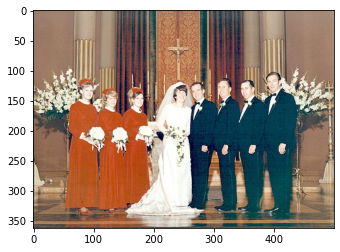

In [52]:
def predict_captions(image):
    start_word = ["sos"]
    c=0
    while True:
        par_caps = [tokenizer1.word_index[i] for i in start_word]
#         print(np.array(par_caps).shape)
        par_caps = pad_sequences([par_caps], maxlen=20, padding='post')
#         print(np.array(par_caps).shape)
        par_caps = [embedding_matrix[i,:] for i in par_caps]
#         print(np.array(par_caps).shape)
        model.set_tensor(input_details_model[0]['index'], np.expand_dims(image,axis=0).astype(np.float32))
        model.set_tensor(input_details_model[1]['index'], np.array(par_caps).astype(np.float32))
        model.invoke()
        preds = model.get_tensor(output_details_model[0]['index'])
#         print(np.sum(preds[0][c]))
#         if c!=1:
        word_pred = tokenizer1.index_word[np.argmax(preds[0][c])]
#         else:
#             word_pred = 'a'
        start_word.append(word_pred)
        c+=1
        
        if word_pred == "eos" or len(start_word) > 20:
            break
            
    return ' '.join(start_word[1:-1])

id_no = 78
# 'archive/Images/'+X_test['image'].values[id_no]
img = cv2.imread('archive/images/'+X_test['image'].values[71])
# img = cv2.imread('test/test11.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
img = cv2.resize(img,(224,224),interpolation=cv2.INTER_AREA)
img = img/255.0
Argmax_Search = predict_captions(img)

In [53]:
# print('true: ',y_test.values[id_no])
print('predicted: ',Argmax_Search)

predicted:  a group of people stand at a bar
